### Lista de exercícios - exercício 1

**Aluno:** André F. Oliveira

Este código foi escrito de forma a tornar todo o processo de cálculo o mais automático possível. Dessa forma, o algoritmo realiza todos os processos tendo apenas o número N de pontos e a quantidades de sinais a ser gerada como entrada. Todos os resultados são exibidos em sequência e de uma única vez. Este mesmo modelo de programa foi utilizado nos exercícios 2 e 3, mas aqui explicarei com mais detalhes o seu funcionamento.

Primeiramente devem ser fornecidos os valores da quantidade de pontos N e quantas famílias de sinais devem ser criadas, no formato: ```GeradorRuido(N,sinais=10,histograma=False)```, onde o parâmetro *histograma* é opcional e informa ao algoritmo se o usuário deseja graficar os histogramas de todos os sinais. Com base nestas informações o código calcula a quantidade de sinais estipulada para cada família N de pontos com o algoritmo: ```np.random.randn(n) * sqrt(res) * sqrt(1 / n)).cumsum()```.

Os sinais são então normalizados, na função ```normalizador```, com o uso da equação:<br><br>
$$x_{norm} = \frac{x-x_{min}}{x_{max}-x_{min}}$$

Após a normalização dos sinais, afunção ```momentos_estatisticos``` determina os momentos estatísticos destes sinais com o uso da seguintes equações:<br><br>
$$m_{r} = \sum_{i=1}^n \frac{(A_{i} - \overline{A})^r}{n}, ~~~~~~~ r \geq 2 $$<br>
$$Variancia (m_{2}) = \frac{1}{n} \sum_{i=1}^n (A_{i}-\overline{A})^2$$<br>
$$Assimetria (m_{2},m_{3}) = S(n) = \frac{\sqrt{n(n-1)}}{n-2} \times \frac{m_{3}}{m_{2}^{3/2}}$$<br>
$$Curtose (m_{2},m_{4}) = K(n) = \frac{(n-1)(n+1)}{(n-2)(n-3)} \times \frac{m_{4}}{m_{2}^2} - 3 \times \frac{(n-1)^2}{(n-2)(n-3)}$$<br>

Os momentos estatísticos de cada uma das N famílias de pontos são então guardados em seu respectivo dataframe e todos estes dataframes são guardados em uma única lista. Após a geração dos momentos de todas as famílias, os dataframes desta lista são concatenados e um único objeto que é então fornecido ao algoritmo do k-means. O pacote ```yellowbrick``` possui um módulo que calcula o k ótimo para a clusterização com base na minização do quadro das distância entre cada ponto e centróide a que ele foi designado. Este valor ótimo é fornecido automaticamente ao algoritmo do k-means que agrupa estes pontos.

Em seguida são plotados os resultados obtidos pelo k-means, mostrando tanto a distribuição dos momentos estatísticos dos sinais tomados dois a dois quanto a distribuição dos pontos no espaço de parâmetros formado pela variância, assimetria e curtose. Ao usuário é então mostrado o cluster a que cada sinal foi designado na forma de uma tabela. O usuário pode então escolher graficar ou não algum destes sinais. Caso haja esta intenção, são pedidos a família de pontos e a iteração a ser graficada, no formato ```n:64 iter:6``` por exemplo. O algoritmo então plota a amplitude do sinal de acordo com os n passos no tempo e o histograma desse sinal paralelamente, o que permite uma visualização clara da distribuição do sinal.

Por fim, é perguntado ao usuário se ele deseja salvar os resultados obtidos em arquivos csv. Caso a resposta seja positiva, os diretórios ```sinais```, ```momentos``` e ```kmeans``` são criados para guardar os sinais obtidos, seus momentos e um arquivo com o resultado do algoritmo do k-means que mostra os momentos de cada um dos sinais e a que cluster ele foi designado. Caso os diretórios já existam, o algoritmo verifica seu conteúdo e dá nomes diferentes para os próximos arquivos a serem salvos. Por exemplo, se o arquivo *momentos_0.csv* já existe, o arquivo *momentos_1.csv* é criado.

Em seguida é mostrado o código em sua totalidade, um exemplo de execução e uma discussão dos resultados obtidos.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import os
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 15


def fold_creator(path):
    """
    Se o diretório não existe, cria o diretório com o valor de path
    """
    if not os.path.exists(path):
        os.makedirs(path)


def nome_unico(nome_arquivo):
    """
    Se o arquivo existe, adiciona um número ao seu nome.
    Ex: se momentos_1.csv existe, cria arquivo momentos_2.csv
    """
    f = 0
    while os.path.exists(nome_arquivo):
        f += 1
        ext = '.' + nome_arquivo.split('.')[1]
        num = int(nome_arquivo.split('.')[0][-1]) + f
        nome_arquivo = nome_arquivo.split('.')[0][:-1] + str(num) + ext
    return nome_arquivo


class GeradorRuido:
    """
    Gerador de Série Temporal Estocástica - V.1.2 por R.R.Rosa.
    Trata-se de um gerador randômico não-gaussiano sem classe de universalidade via PDF.
    """

    def __init__(self, n, sinais, histograma=False):
        """
        Inicializador dos parâmetros de entrada
        =======================================
        Inputs
        n: número de pontos. São consideradas 8 famílias de pontos 2**n com n no intervalo [6,13]
        sinais: quantidade de sinais a serem gerados para cada família de pontos
        histograma: mostra na tela os histogramas de cada família de sinais. Padrão é False
        """

        self.n_sinais = sinais
        self.hist = histograma

        # Instâncias que serão declaradas nas funções
        self.df = None
        self.df_norm = None
        self.df_stats = None

        # Listas para armazenar cada família de sinal para uso posterior
        self.sinais = []
        self.sinais_normalizados = []
        self.momentos = []
        self.k_means = []

        # Se n não for uma lista, transforma em lista
        if not isinstance(n, list):
            n = list(n)

        # Executa o código para cada valor de n
        for num in n:
            self.sinal(num)

        # Depois de executar todo o código, calcula o k-means
        self.kmeans()

        # Depois de executar o k-means, pergunta se o usuário deseja plotar os sinais
        self.plot_sinais()

        # Depois de plotar os sinais, pergunta se o usuário deseja salvar os arquivos csv
        salva = False
        while True:
            try:
                s = int(input('\n\nDeseja salvar os valores dos momentos estatísticos e k-means '
                              'em arquivos csv? (0- Não, 1- Sim): '))
            except ValueError:
                print('\n\nDigite 0 para não salvar e 1 para salvar os arquivos em formato csv')
                continue
            else:
                if s == 1:
                    salva = True
                    break
                elif s == 0:
                    break
                else:
                    print('\n\nDigite 0 para não salvar e 1 para salvar os arquivos em formato csv')
                    continue

        if salva:
            self.salva_arquivos()
            

    def sinal(self, n):
        """
        Gera uma quantidade de sinais definida pelo usuário
        """

        tmp = []
        res = n / 12
        for j in range(self.n_sinais):
            tmp.append((np.random.randn(n) * np.sqrt(res) * np.sqrt(1 / n)).cumsum())

        self.df = pd.DataFrame(np.transpose(tmp), columns=self.colnames(n)).astype('float64')
        self.sinais.append(self.df)

        # Chamando a próxima função
        self.normalizador(n)
        

    def normalizador(self, n):
        """
        Normaliza entre 0 e 1 os valores do dataframe fornecido
        """

        # Cria uma cópia do dataframe para ser utilizado somente dentro da função
        tmp1 = self.df.copy()

        # Altera o nome das colunas para uma melhor manipulação
        tmp1.columns = [x for x in range(self.n_sinais)]

        tmp = []
        for i in range(self.n_sinais):
            tmp.append((tmp1[i] - min(tmp1[i])) / (max(tmp1[i]) - min(tmp1[i])))

        self.df_norm = pd.DataFrame(np.transpose(tmp), columns=self.colnames(n))
        self.sinais_normalizados.append(self.df_norm)

        # Chama a próxima função
        self.momentos_estatisticos(n)
        

    def momentos_estatisticos(self, n):
        """
        Calcula os momentos estatísticos dos ruídos gerados pela função sinal
        """
        # Cria uma cópia do dataframe para ser utilizado somente dentro da função
        tmp = self.df_norm.copy()

        # Altera o nome das colunas para uma melhor manipulação
        tmp.columns = [x for x in range(self.n_sinais)]

        # Função geradora de momentos
        f = lambda i, r: sum((tmp[i] - sum(tmp[i]) / len(tmp[i])) ** r)

        # Variancia
        var = []
        coeff_var = (1 / n)

        for i in range(self.n_sinais):
            var.append(coeff_var * f(i, 2))

        # Assimetria
        skew = []
        coeff_skew = (sqrt(n * (n - 1)) / (n - 2))

        for j in range(self.n_sinais):
            skew.append(coeff_skew * (coeff_var * f(j, 3) / var[j] ** 1.5))

        # Curtose
        coeff_kurt1 = ((n - 1) * (n + 1)) / ((n - 2) * (n - 3))
        coeff_kurt2 = 3 * ((n - 1) ** 2) / ((n - 2) * (n - 3))
        kurt = []

        for k in range(self.n_sinais):
            kurt.append(coeff_kurt1 * (coeff_var * f(k, 4) / var[k] ** 2) - coeff_kurt2)

        self.df_stats = pd.DataFrame(np.transpose((self.colnames(n), var, skew, kurt)),
                                     columns=['index', 'variance', 'skewness',
                                              'kurtosis']).set_index('index').astype('float64')

        # Guardando cada dataframe em uma lista
        self.momentos.append(self.df_stats)

        # Chamando a próxima função se histrograma=True
        if self.hist:
            self.histograma(n)
            

    def histograma(self, n):
        """
        Grafica os histogramas dos sinais gerados
        """
        fig = plt.figure(figsize=(14, 14))
        number_of_subplots = self.n_sinais
        # Gera um grid para o plot dos histogramas para qualquer quantidade de sinais
        for i, v in enumerate(range(number_of_subplots)):
            v = v + 1
            axes_hist = subplot(number_of_subplots, 1, v)

        # Para garantir que os bins tenham os mesmos tamanhos
        f = int(n / 64)
        b = int(n / (3 * f))

        hist_plot = self.df_norm.hist(bins=b, ec="k", alpha=0.6, color='royalblue', ax=axes_hist)

        fig.text(0.5, 1.0, 'N = ' + str(n), ha='center', fontsize=15)
        fig.text(0.5, 0.0, 'Valores de Amplitude Normalizados', ha='center', fontsize=14)
        fig.text(0.0, 0.5, 'Contagem', va='center', rotation='vertical', fontsize=14)
        fig.tight_layout(pad=3.0, h_pad=1.0)

        plt.show()
        

    def kmeans(self):
        """
        Calcula o k-means para o dataframe contendo os valores dos momentos estatísticos
        """

        # Carrega o dataset com os momentos estatísticos
        df_kmeans = pd.concat(self.momentos.copy(), join='inner')

        # Determinando o número ótimo de clusters
        model = KMeans()
        visualizer = KElbowVisualizer(model, k=(1, 10))
        visualizer.fit(df_kmeans)
        plt.close()

        # Calculando o k-means
        n_clusters = visualizer.elbow_value_  # Número ótimo de clusters
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(df_kmeans)
        df_kmeans['K_classes'] = kmeans.labels_
        self.k_means.append(df_kmeans)

        # Plotando as relações a pares de cada medida estatística (seaborn)
        colors = sns.color_palette('tab10', n_clusters)
        g = sns.pairplot(df_kmeans, 'K_classes', palette=colors)
        g.fig.suptitle('\n\nEspaço de parâmetros: V x S x K', y=1.09)

        plt.show()

        # Plotando os pontos em 3 dimensões
        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(111, projection='3d')

        labels = df_kmeans.groupby('K_classes')
        for key, item in labels:
            ax.scatter(item['variance'], item['skewness'], item['kurtosis'], label=key,
                       alpha=1, s=200, edgecolors='b', c=[colors[key]])

        # Plotandos os centróides em 3 dimensões
        x = []
        y = []
        z = []
        for row in kmeans.cluster_centers_:
            x.append(row[0])
            y.append(row[1])
            z.append(row[2])

        ax.scatter(x, y, z, alpha=0.4, s=500, label='Centróides')

        # Ajustando os eixos
        ax.set_xlabel('\n\n' + df_kmeans.columns[0], fontsize=20)
        ax.set_ylabel('\n\n' + df_kmeans.columns[1], fontsize=20)
        ax.set_zlabel('\n\n' + df_kmeans.columns[2], fontsize=20)
        ax.xaxis.set_tick_params(labelsize=18)
        ax.yaxis.set_tick_params(labelsize=18)
        ax.zaxis.set_tick_params(labelsize=18)

        plt.tight_layout()
        plt.legend(loc='best', fontsize=20)
        plt.show()
        

    def plot_sinais(self):
        """
        Plota um sinal e seu histograma correspondente à escolha do usuário
        """

        cluster = pd.concat(self.k_means.copy())

        # Mostra os sinais presentes em cada cluster
        for classe in pd.unique(cluster['K_classes']):
            print(f'\n\n****************** Sinais na classe {classe} ******************')
            print(cluster.loc[cluster['K_classes'] == classe])

        sinais = pd.concat(self.sinais, axis=1)

        while True:
            try:
                p = int(input('\n\nDeseja plotar algum dos sinais? (0- Não, 1- Sim): '))
            except ValueError:
                print('\n\nDigite 0 para não plotar ou 1 para plotar')
                continue
            else:
                if p == 1:
                    try:
                        a = int(input('Valor de N: '))
                        b = int(input('Número da iteração: '))
                    except ValueError:
                        print('\n\nDigite o valor de N e da iteração cujo sinal deseja graficar')
                    else:
                        if not 'n:' + str(a) + ' ' + 'iter:' + str(b) in sinais.columns:
                            print('\n\nValores inválidos!')
                            continue
                        else:

                            for nome in cluster.index.values:
                                valor_n = nome.split(' ')[0]
                                valor_iter = nome.split(' ')[1]

                                if 'n:' + str(a) == valor_n and 'iter:' + str(b) == valor_iter:
                                    fig, ax = plt.subplots(1, 2, sharey=True, squeeze=False, figsize=(18, 7),
                                                           gridspec_kw={'width_ratios': [3.5, 1]})
                                    ax[0, 0].plot(sinais[valor_n + ' ' + valor_iter], color='cornflowerblue')
                                    ax[0, 1].hist(sinais[valor_n + ' ' + valor_iter], ec='k', 
                                                  color='cornflowerblue',orientation='horizontal')

                                    ax[0, 0].set_xlabel('Tempo (t)')
                                    ax[0, 0].set_ylabel('Amplitude A(t)')
                                    ax[0, 0].set_title('n:' + str(a) + ' ' + 'iter:' + str(b))

                                    ax[0, 1].set_xlabel('Contagem')
                                    plt.tight_layout()
                                    plt.show()

                elif int(p) == 0:
                    break
                
                else:
                    print('\n\nDigite 0 para não plotar ou 1 para plotar')
                    
                    

    def colnames(self, n):
        """
        Retorna uma lista com as strings dos valores de N e sinal atuais
        """

        col = []
        for i in range(self.n_sinais):
            col.append('n:' + str(n) + ' ' + 'iter:' + str(i))

        return col
    

    def salva_arquivos(self):
        """
        Salva os arquivos em seus respectivos diretórios
        """
        # Cria o diretório para salvar os sinais
        path = 'sinais/'
        fold_creator(path)
        tmp = pd.concat(self.sinais.copy(), axis = 1)
        nome_arquivo = path + 'sinais_0.csv'
        nome_arquivo = nome_unico(nome_arquivo)

        tmp.to_csv(nome_arquivo, index=True)
        
        # Cria o diretório para salvar os momentos estatísticos
        path = 'momentos/'
        fold_creator(path)
        tmp = pd.concat(self.momentos.copy(), join='inner')
        nome_arquivo = path + 'momentos_0.csv'
        nome_arquivo = nome_unico(nome_arquivo)

        tmp.to_csv(nome_arquivo, index=True)

        # Cria o diretório para salvar os resultados so kmeans
        path = 'kmeans/'
        fold_creator(path)
        tmp = pd.concat(self.k_means.copy(), join='inner')
        nome_arquivo = path + 'k_means_0.csv'
        nome_arquivo = nome_unico(nome_arquivo)

        tmp.to_csv(nome_arquivo, index=True)

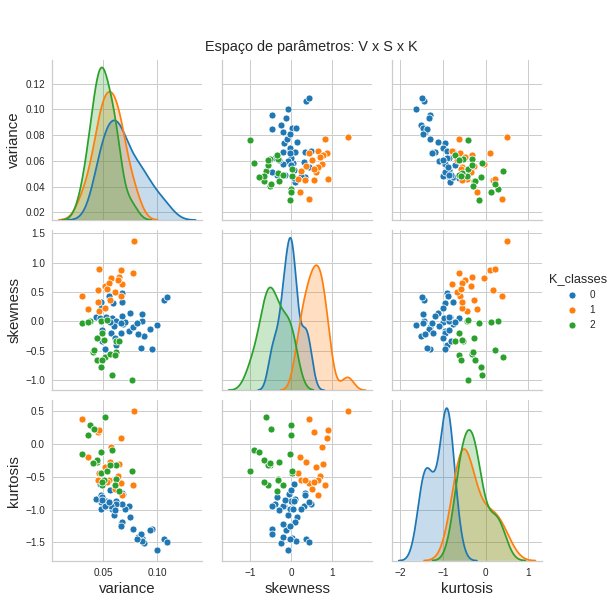

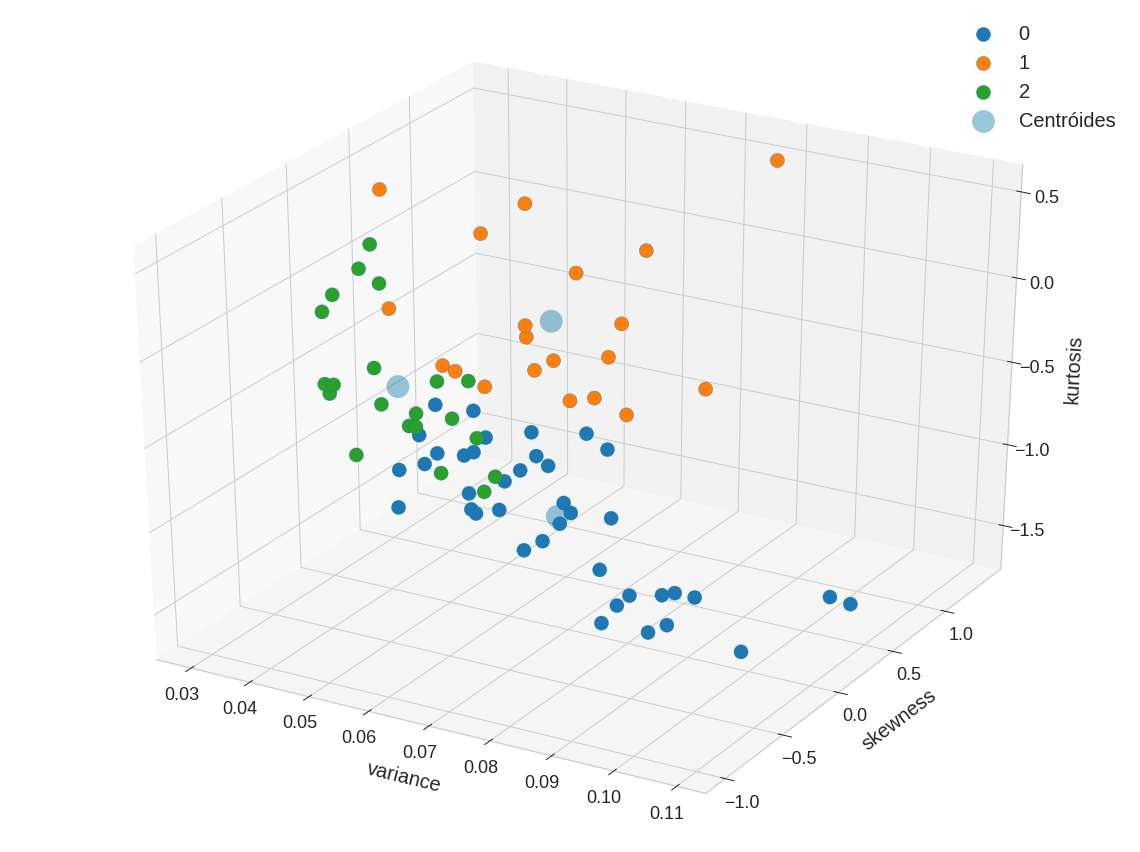



****************** Sinais na classe 1 ******************
               variance  skewness  kurtosis  K_classes
index                                                 
n:64 iter:0    0.056122  0.364273 -0.277124          1
n:64 iter:2    0.057168  0.737701 -0.048875          1
n:64 iter:3    0.067449  0.643137 -0.779669          1
n:64 iter:5    0.066068  0.434361 -0.595298          1
n:64 iter:9    0.066171  0.876048  0.090504          1
n:128 iter:6   0.064311  0.761925 -0.308274          1
n:128 iter:7   0.077287  0.818681 -0.626099          1
n:256 iter:2   0.063133  0.709201 -0.493968          1
n:256 iter:7   0.045082  0.542402  0.177532          1
n:512 iter:5   0.060790  0.496251 -0.680107          1
n:512 iter:7   0.030588  0.424341  0.381566          1
n:1024 iter:0  0.078367  1.371129  0.502006          1
n:1024 iter:2  0.045883  0.172052 -0.439346          1
n:1024 iter:8  0.051767  0.228969 -0.546237          1
n:1024 iter:9  0.036016  0.217751 -0.193783          1
n:2048

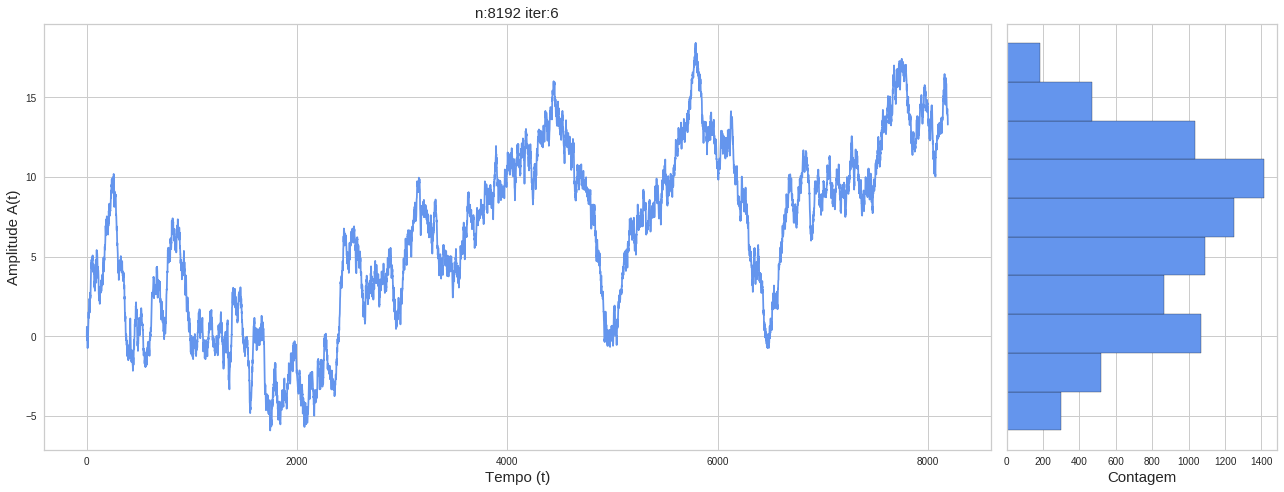



Deseja plotar algum dos sinais? (0- Não, 1- Sim): 1
Valor de N: 8192
Número da iteração: 9


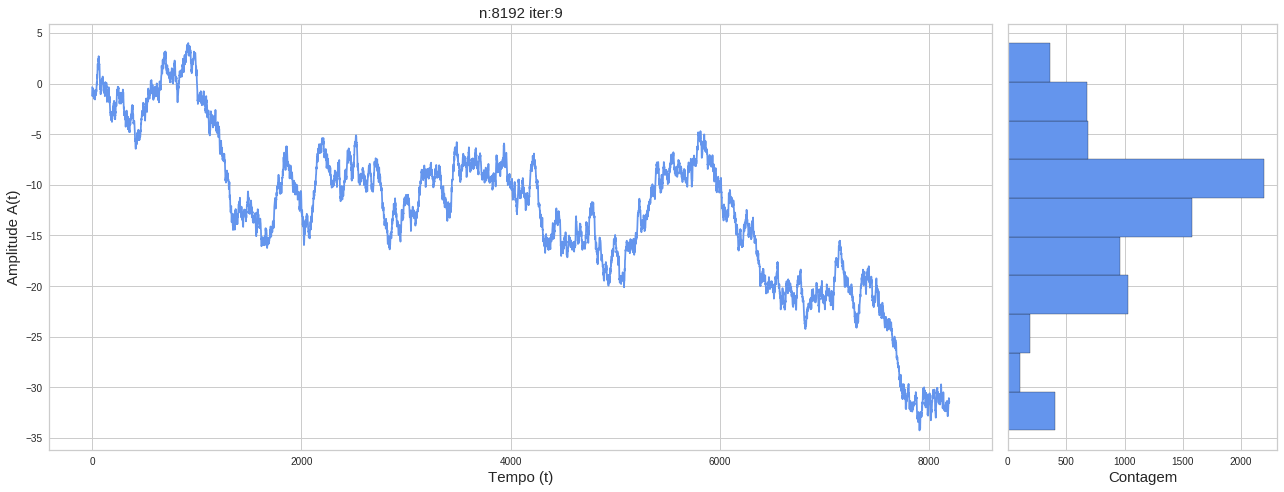



Deseja plotar algum dos sinais? (0- Não, 1- Sim): 1
Valor de N: 128
Número da iteração: 7


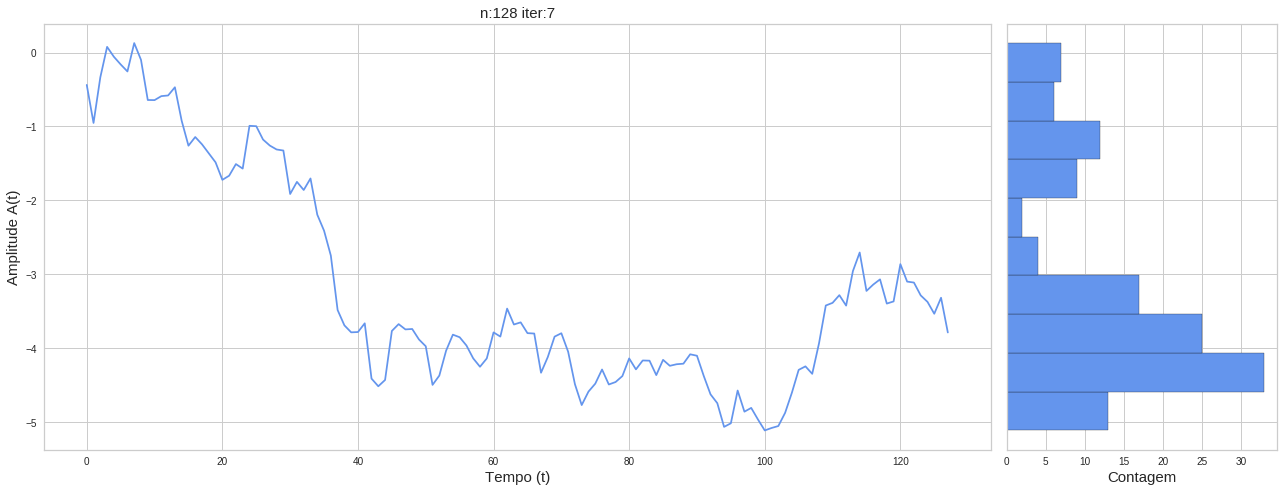



Deseja plotar algum dos sinais? (0- Não, 1- Sim): 0


Deseja salvar os valores dos momentos estatísticos e k-means em arquivos csv? (0- Não, 1- Sim): 0


In [6]:
# Lista com a quantidade de pontos em cada família
N = [2**n for n in range(6,13+1)]

GeradorRuido(N,sinais=10)

O resultado mais interessante é mostrado nos gráficos referentes ao resultado do k-means. Nele é possível ver que apesar de serem fornecidas oito famílias de pontos diferentes, o algoritmo as alocou em apenas três grupos no espaço de parâmetros formado pela variância, assimetria e curtose. Isto indica que ouve uma invariância desses valores ao longo de todas as famílias de pontos. De fato, o plot 3D mostra que os valores destes momentos se mantiveram em uma faixa de valores muito pequena. Isto mostra que estas medidas estatísticas sozinhas não são suficientes para separar e classificar estas famílias de forma satisfatória.

Outro resultado que deixa isto claro é a tabela contendo a identificação de cada um dos sinais quanto ao cluster a que ele foi designado. Note que sinais da família N:64 foram alocados juntos à sinais da família N:8192, ou seja, o número de pontos de uma família não é relevante para determinar a qual grupo este sinal será alocado tendo seus momentos estatísticos como base.